In [5]:
import pandas as pd
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from src.secrets.authentication import get_authentication
import functools
import operator

In [22]:
def normalize_list(nested_list): # estandariza la lista
    regular_list = []
    for ele in nested_list:
        if type(ele) is list:
            regular_list.append(ele)
        else:
            regular_list.append([ele])
    return regular_list

# Global variables

In [24]:
CREDENTIALS_FILE = '../config/credentials/credentials.json'
RAW_DATA_PATH = '../data/reviews/raw/1668080225'
PROC_DATA_PATH = '../data/reviews/proc/'

# Get keys from credentials

In [25]:
URL, API_KEY = get_authentication(CREDENTIALS_FILE)
service = NaturalLanguageUnderstandingV1(authenticator=IAMAuthenticator(API_KEY),  version='2018-03-16')
service.set_service_url(URL)

# 1. Load data and fill missing values

In [30]:
reviews_data = pd.read_csv(RAW_DATA_PATH)

In [31]:
reviews_data.isnull().sum()

title          0
content        9
date           0
variant      312
images      1909
verified       0
author         0
rating         0
product        0
url         2053
dtype: int64

In [32]:
reviews_data.loc[reviews_data.content.isnull(), 'content'] = reviews_data.loc[reviews_data.content.isnull(), 'title']

# 2. Get sentiment and keywords

Here just the sentiment and keywords are retrieved. Objetives:

1. Get the most common keywords
2. Get the rate of positive reviews

In [33]:
from src.IBMNLU.APICalls import sentiment_and_keyword

In [34]:
sentiment = []
keywords = []

for index, review in enumerate(reviews_data.content[:200]): # solo 200 resultados
    try:
        
        response = sentiment_and_keyword(review, service)
        
        reviews_data.loc[index, 'sentiment_label'] = response['sentiment']['document']['label']
        
        sentiment.append([index]+list(response['sentiment']['document'].values()))
        
        kw = []
        for keyword in response['keywords']:
            kw.append(list(keyword.values())[0])
            
        keywords.append(kw)
        
    except:
        pass

In [38]:
reviews_data['keywords'] = pd.Series(keywords)

In [39]:
bag_of_words = functools.reduce(operator.iconcat, normalize_list(keywords), []) # lista de keywords.

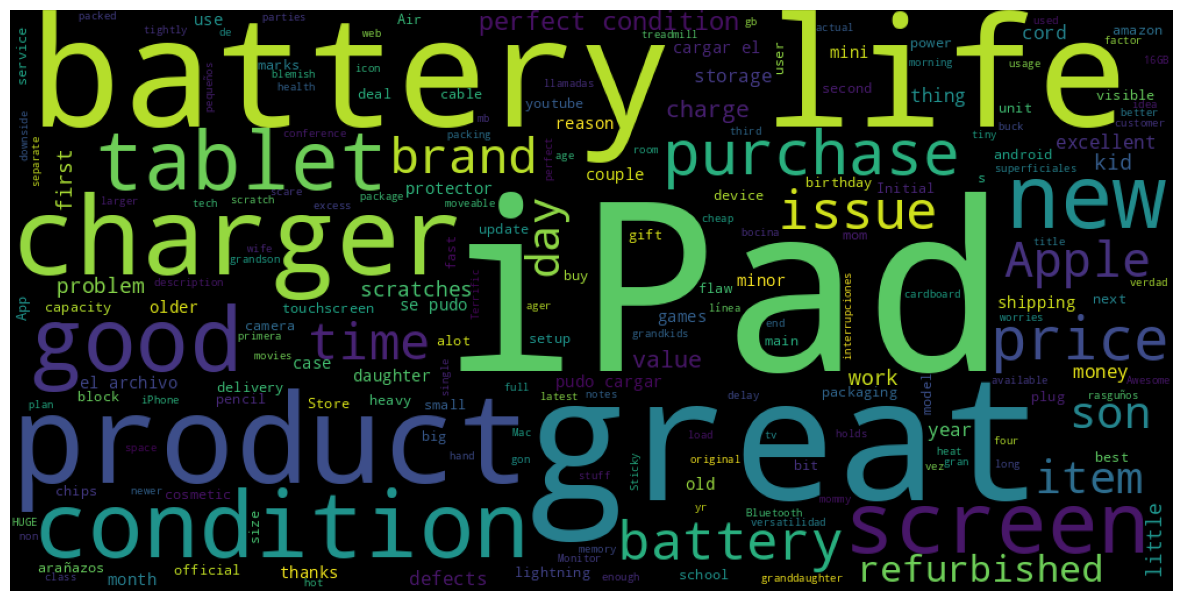

In [41]:
unique_string=(" ").join(bag_of_words)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('../figures/sample/sample_analysis.png')
plt.show()
plt.close()

It seems clear that, when looking for this type of Ipad we should care about: charger, battery life and that it will be, probably, in great conditions.

In [42]:
reviews_data.sentiment_label.value_counts(normalize=True)

positive    0.732984
negative    0.225131
neutral     0.041885
Name: sentiment_label, dtype: float64

More than 70% of customers posted positve reviews.

# 3. Save results

In [ ]:
reviews_data.to_csv(PROC_DATA_PATH+'1668080225_proc', index=False)